In [1]:
import argparse
import dynamo as dyn
import scanpy as sc
import gc
from pathlib import Path
import warnings
import utils
import importlib
import pandas as pd
import anndata as ad
import mygene
import scvelo as scv
import numpy as np
importlib.reload(utils)
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
dyn.configuration.set_figure_params('dynamo', background='white')
dyn.get_all_dependencies_version()
%load_ext autoreload
%autoreload 2

package,mudata,umap-learn,pynndescent,numdifftools,leidenalg,igraph,seaborn,statsmodels,numba,session-info,dynamo-release,scipy,pandas,loompy,colorcet,openpyxl,networkx,matplotlib,pre-commit,typing-extensions,tqdm,setuptools
version,0.2.3,0.5.7,0.5.13,0.9.41,0.10.2,0.11.8,0.13.2,0.14.4,0.61.0,1.0.0,1.4.2rc1,1.15.2,2.2.3,3.0.8,3.1.0,3.1.5,3.4.2,3.10.0,4.1.0,4.12.2,4.62.3,59.5.0


In [2]:
DATA_DIR = Path("/root/autodl-tmp/dataset") 
DATASET = "labeled_human"
K_FOLD = 3
CLUSTER_KEY = 'cell_type'
SEED = 1234

In [3]:
(DATA_DIR / DATASET / "raw").mkdir(parents=True, exist_ok=True)
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

In [4]:
adata = sc.read(DATA_DIR / DATASET / "raw" / "hematopoiesis_raw.h5ad")
selected_genes_to_use = adata.uns["genes_to_use"]

In [5]:
import mygene
import pandas as pd
mg = mygene.MyGeneInfo()
gene_ids = adata.var_names.tolist()

In [6]:
out = mg.querymany(
    gene_ids,
    scopes="ensembl.gene",  # 输入ID的类型
    fields="symbol",        # 我们需要返回的字段
    species="human",        # 物种
    as_dataframe=True       # 直接返回DataFrame，更简洁
)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
17 input query terms found dup hits:	[('ENSG00000175711', 2), ('ENSG00000226519', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('E
472 input query terms found no hit:	['ENSG00000002079', 'ENSG00000112096', 'ENSG00000132832', 'ENSG00000148362', 'ENSG00000168078', 'ENS


In [7]:
out = out.dropna(subset=['symbol'])
out = out[~out.index.duplicated(keep='first')]
id2symbol = out['symbol'].to_dict()
adata.var_names = [id2symbol.get(gid, gid) for gid in adata.var_names]
adata.var_names_make_unique()
print("基因ID已成功映射为基因符号。")

基因ID已成功映射为基因符号。


In [8]:
adata.obs

,batch,cell_type,time
barcode,,,
CCACAAGCGTGC-JL12_0,JL12_0,Mon,3
CCATCCTGTGGA-JL12_0,JL12_0,Meg,3
CCCTCGGCCGCA-JL12_0,JL12_0,Mon,3
CCGCCCACCATG-JL12_0,JL12_0,Mon,3
CCGCTGTGTAAG-JL12_0,JL12_0,MEP-like,3
...,...,...,...
GTGAACCTGTGA-JL12_1,JL12_1,MEP-like,3
GTGAGACAATAC-JL12_1,JL12_1,MEP-like,3
GTGATATTGACC-JL12_1,JL12_1,MEP-like,3


In [8]:
# common_genes_set = set(selected_genes_to_use) & set(adata.var_names)
# common_genes = list(common_genes_set)
# adata = adata[:,common_genes]

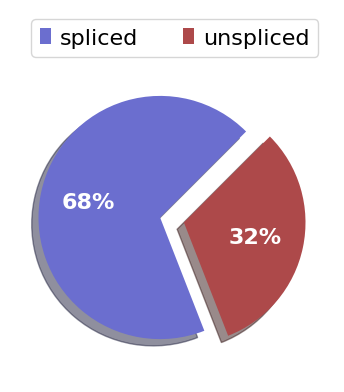

In [9]:
scv.pl.proportions(adata)

In [10]:
sub_adata_lst = utils.split_anndata_stratified(adata, n_splits=K_FOLD, cluster_key=CLUSTER_KEY)

In [11]:
selected_genes_to_use = list(selected_genes_to_use)

In [12]:
sub_adata_lst[0]

AnnData object with n_obs × n_vars = 649 × 26193
    obs: 'batch', 'cell_type', 'time'
    var: 'gene_name_mapping'
    uns: 'genes_to_use'
    obsm: 'X_umap'
    layers: 'new', 'spliced', 'total', 'unspliced'

In [9]:
sub_adata = adata.copy()
sub_adata.layers['raw_spliced'] = sub_adata.layers['spliced']
sub_adata.layers['raw_unspliced'] = sub_adata.layers['unspliced']
scv.pp.filter_and_normalize(
    sub_adata,
    min_shared_counts=5,
    n_top_genes=None  # 不在这里限制基因数，先过滤
)
sc.pp.highly_variable_genes(sub_adata, n_top_genes=2000, subset=False)
hvg_genes = set(sub_adata.var_names[sub_adata.var["highly_variable"]])
selected_genes_in_adata = set(sub_adata.var_names) & set(selected_genes_to_use)
final_genes = list(hvg_genes | selected_genes_in_adata)
sub_adata = sub_adata[:, final_genes].copy()
print(sub_adata.n_vars)
if 'X_pca' in sub_adata.obsm:
    del sub_adata.obsm['X_pca']
if 'pca' in sub_adata.uns:
    del sub_adata.uns['pca']
if "neighbors" in sub_adata.uns.keys():
    del sub_adata.uns['neighbors']
scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
utils.fill_in_neighbors_indices(sub_adata)
sc.tl.umap(sub_adata, random_state=SEED)
sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].toarray().sum(-1) 
sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].toarray().sum(-1)
if SAVE_DATA:
    sub_adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_full.h5ad")
del sub_adata
gc.collect()

for i in range(K_FOLD):
    sub_adata = sub_adata_lst[i].copy()
    sub_adata.layers['raw_spliced'] = sub_adata.layers['spliced']
    sub_adata.layers['raw_unspliced'] = sub_adata.layers['unspliced']
    scv.pp.filter_and_normalize(
        sub_adata,
        min_shared_counts=5,
        n_top_genes=None  # 不在这里限制基因数，先过滤
    )
    sc.pp.highly_variable_genes(sub_adata, n_top_genes=2000, subset=False)
    hvg_genes = set(sub_adata.var_names[sub_adata.var["highly_variable"]])
    selected_genes_in_adata = set(sub_adata.var_names) & set(selected_genes_to_use)
    final_genes = list(hvg_genes | selected_genes_in_adata)
    sub_adata = sub_adata[:, final_genes].copy()
    print(sub_adata.n_vars)
    if 'X_pca' in sub_adata.obsm:
        del sub_adata.obsm['X_pca']
    if 'pca' in sub_adata.uns:
        del sub_adata.uns['pca']
    if "neighbors" in sub_adata.uns.keys():
        del sub_adata.uns['neighbors']
    scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
    utils.fill_in_neighbors_indices(sub_adata)
    sc.tl.umap(sub_adata, random_state=SEED)
    sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].toarray().sum(-1) 
    sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].toarray().sum(-1)
    if SAVE_DATA:
        sub_adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_{i}.h5ad")
    del sub_adata
    gc.collect()

Filtered out 21103 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


2091


/tmp/ipykernel_914/1559167652.py:21: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


87638

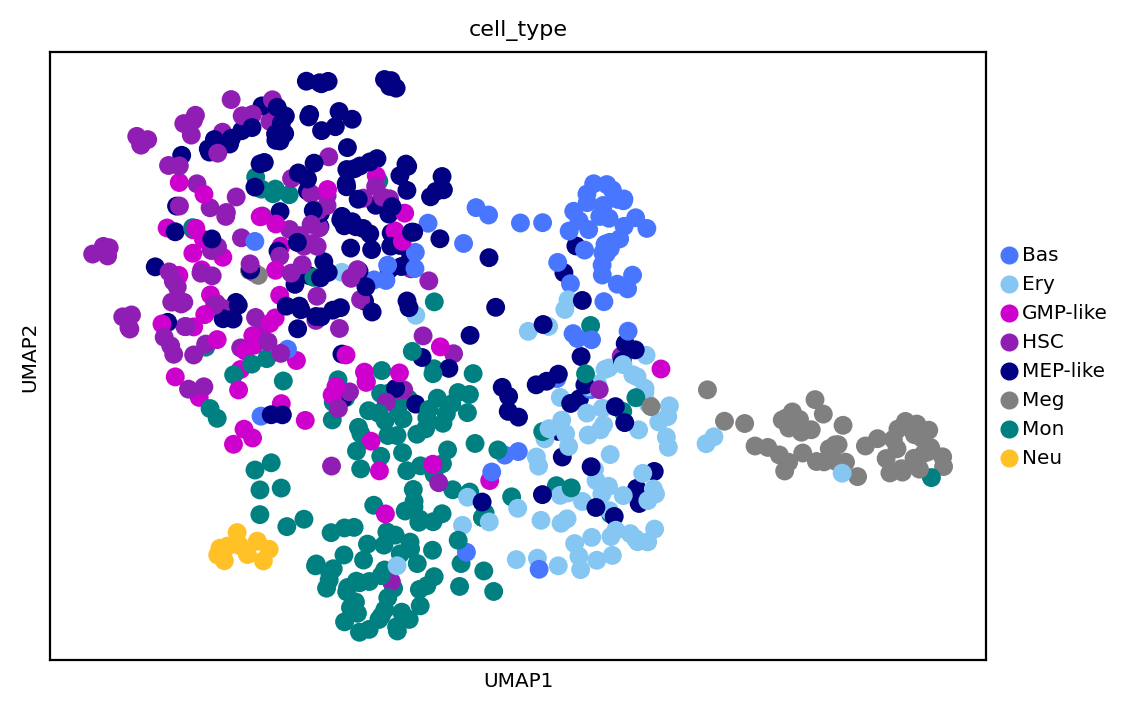

In [27]:
sub_adata = sc.read(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_0.h5ad")
sc.pl.umap(sub_adata,color='cell_type')